In [1]:
from pennylane import numpy as np
import matplotlib as mpl

np.random.seed(1359)

In [2]:
def _make_circular_data(num_sectors, points_per_sector):
    """Generate datapoints arranged in an even circle."""
    center_indices = np.repeat(np.array(range(0, num_sectors)), points_per_sector)
    sector_angle = 2 * np.pi / num_sectors
    angles = (center_indices + np.random.rand(center_indices.shape[0])) * sector_angle  # Add randomness for more points
    
    x = 0.7 * np.cos(angles)
    y = 0.7 * np.sin(angles)
    labels = 2 * np.remainder(np.floor_divide(center_indices, 1), 2) - 1

    return x, y, labels

def make_double_cake_data(num_sectors, points_per_sector=1):
    x1, y1, labels1 = _make_circular_data(num_sectors, points_per_sector)
    x2, y2, labels2 = _make_circular_data(num_sectors, points_per_sector)

    # x and y coordinates of the datapoints
    x = np.hstack([x1, 0.5 * x2])
    y = np.hstack([y1, 0.5 * y2])

    # Canonical form of dataset
    X = np.vstack([x, y]).T

    labels = np.hstack([labels1, -1 * labels2])

    # Canonical form of labels
    Y = labels.astype(int)

    return X, Y

In [3]:
def plot_double_cake_data(X, Y, ax, num_sectors=None):
    """Plot double cake data and corresponding sectors."""
    x, y = X.T
    cmap = mpl.colors.ListedColormap(["#FF0000", "#0000FF"])
    ax.scatter(x, y, c=Y, cmap=cmap, s=25, marker="s")

    if num_sectors is not None:
        sector_angle = 360 / num_sectors
        for i in range(num_sectors):
            color = ["#FF0000", "#0000FF"][(i % 2)]
            other_color = ["#FF0000", "#0000FF"][((i + 1) % 2)]
            ax.add_artist(
                mpl.patches.Wedge(
                    (0, 0),
                    1,
                    i * sector_angle,
                    (i + 1) * sector_angle,
                    lw=0,
                    color=color,
                    alpha=0.1,
                    width=0.5,
                )
            )
            ax.add_artist(
                mpl.patches.Wedge(
                    (0, 0),
                    0.5,
                    i * sector_angle,
                    (i + 1) * sector_angle,
                    lw=0,
                    color=other_color,
                    alpha=0.1,
                )
            )
            ax.set_xlim(-1, 1)

    ax.set_ylim(-1, 1)
    ax.set_aspect("equal")
    ax.axis("off")

    return ax

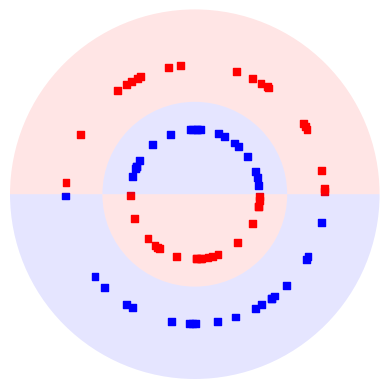

In [4]:
import matplotlib.pyplot as plt

num_sectors = 2
X, Y = make_double_cake_data(num_sectors, 20)
ax = plot_double_cake_data(X, Y, plt.gca(), num_sectors=num_sectors)

In [5]:
import pennylane as qml

circuit_executions = 0
def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])

def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))


adjoint_ansatz = qml.adjoint(ansatz)


def random_params(num_wires, num_layers):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires), requires_grad=True)

dev = qml.device("default.qubit", wires=5, shots=None)
wires = dev.wires.tolist()

@qml.qnode(dev)
def kernel_circuit(x1, x2, params):
    global circuit_executions
    circuit_executions += 1
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(x2, params, wires=wires)
    return qml.probs(wires=wires)

def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)[0]


In [6]:
init_params = random_params(num_wires=5, num_layers=6)


In [7]:
kernel_value = kernel(X[0], X[1], init_params)
print(f"The kernel value between the first and second datapoint is {kernel_value:.3f}")

The kernel value between the first and second datapoint is 0.034


In [8]:
from sklearn.model_selection import train_test_split
from utils.classification_data import linear_data, checkerboard_data, power_line_data, microgrid_data, make_double_cake_data

data = checkerboard_data(2)
print("Done..!")
print("Sample:\n", data.head(1))
print("Data Size:", data.shape)

## Extract features and target
features = np.asarray(data.drop(columns=['target']))
target = np.asarray(data['target'])
target = target % 2
target = 2 * target - 1

X, x_test, Y, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42
)

Done..!
Sample:
    Feature 1  Feature 2  target
0   4.366161    -3.8685      16
Data Size: (60, 3)


In [9]:
init_kernel = lambda x1, x2: kernel(x1, x2, init_params)
K_init = qml.kernels.square_kernel_matrix(X, init_kernel, assume_normalized_kernel=True)

with np.printoptions(precision=3, suppress=True):
    print(K_init)

[[1.    0.046 0.015 ... 0.029 0.003 0.001]
 [0.046 1.    0.007 ... 0.008 0.113 0.121]
 [0.015 0.007 1.    ... 0.008 0.002 0.025]
 ...
 [0.029 0.008 0.008 ... 1.    0.071 0.02 ]
 [0.003 0.113 0.002 ... 0.071 1.    0.004]
 [0.001 0.121 0.025 ... 0.02  0.004 1.   ]]


In [10]:
from sklearn.svm import SVC
svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(X, Y)

In [11]:
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)

In [12]:

accuracy_init = accuracy(svm, X, Y)
print(f"The accuracy of the kernel with random parameters is {accuracy_init:.3f}")


The accuracy of the kernel with random parameters is 0.833


In [13]:
def plot_decision_boundaries(classifier, ax, N_gridpoints=14):
    _xx, _yy = np.meshgrid(np.linspace(-1, 1, N_gridpoints), np.linspace(-1, 1, N_gridpoints))

    _zz = np.zeros_like(_xx)
    for idx in np.ndindex(*_xx.shape):
        _zz[idx] = classifier.predict(np.array([_xx[idx], _yy[idx]])[np.newaxis, :])

    plot_data = {"_xx": _xx, "_yy": _yy, "_zz": _zz}
    ax.contourf(
        _xx,
        _yy,
        _zz,
        cmap=mpl.colors.ListedColormap(["#FF0000", "#0000FF"]),
        alpha=0.2,
        levels=[-1, 0, 1],
    )
    plot_double_cake_data(X, Y, ax)

    return plot_data


In [14]:
#init_plot_data = plot_decision_boundaries(svm, plt.gca())

In [15]:
kta_init = qml.kernels.target_alignment(X, Y, init_kernel, assume_normalized_kernel=True)

print(f"The kernel-target alignment for our dataset and random parameters is {kta_init:.3f}")

The kernel-target alignment for our dataset and random parameters is 0.296


In [16]:
def target_alignment(
    X,
    Y,
    kernel,
    assume_normalized_kernel=False,
    rescale_class_labels=True,
):
    """Kernel-target alignment between kernel and labels."""

    K = qml.kernels.square_kernel_matrix(
        X,
        kernel,
        assume_normalized_kernel=assume_normalized_kernel,
    )

    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product


In [17]:
circuit_executions = 0

params = init_params
opt = qml.GradientDescentOptimizer(0.2)

for i in range(500):
    # Choose subset of datapoints to compute the KTA on.
    subset = np.random.choice(list(range(len(X))), 4)
    # Define the cost function for optimization
    cost = lambda _params: -target_alignment(
        X[subset],
        Y[subset],
        lambda x1, x2: kernel(x1, x2, _params),
        assume_normalized_kernel=True,
    )
    # Optimization step
    params = opt.step(cost, params)

    # Report the alignment on the full dataset every 50 steps.
    if (i + 1) % 50 == 0:
        current_alignment = target_alignment(
            X,
            Y,
            lambda x1, x2: kernel(x1, x2, params),
            assume_normalized_kernel=True,
        )
        print(f"Step {i+1} - Alignment = {current_alignment:.3f}")


Step 50 - Alignment = 0.299
Step 100 - Alignment = 0.303
Step 150 - Alignment = 0.306
Step 200 - Alignment = 0.310
Step 250 - Alignment = 0.313
Step 300 - Alignment = 0.315
Step 350 - Alignment = 0.319
Step 400 - Alignment = 0.323
Step 450 - Alignment = 0.327
Step 500 - Alignment = 0.328


In [18]:
from sklearn.svm import SVC
# First create a kernel with the trained parameter baked into it.
trained_kernel = lambda x1, x2: kernel(x1, x2, params)

# Second create a kernel matrix function using the trained kernel.
trained_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, trained_kernel)

# Note that SVC expects the kernel argument to be a kernel matrix function.
svm_trained = SVC(kernel=trained_kernel_matrix).fit(X, Y)


In [19]:
accuracy_trained = accuracy(svm_trained, X, Y)
print(f"The accuracy of a kernel with trained parameters is {accuracy_trained:.3f}")


The accuracy of a kernel with trained parameters is 0.833


In [20]:
#trained_plot_data = plot_decision_boundaries(svm_trained, plt.gca())

In [21]:
accuracy_trained = accuracy(svm_trained, x_test, y_test)
print(f"The accuracy of a kernel with trained parameters is {accuracy_trained:.3f}")

print("Circuit Executions: ", circuit_executions)
circuit_executions = 0

The accuracy of a kernel with trained parameters is 0.000
Circuit Executions:  15894


In [23]:
from sklearn.cluster import SpectralClustering, KMeans

params = random_params(num_wires=5, num_layers=6)
f_kernel = lambda x1, x2: kernel(x1, x2, params)
get_kernel_matrix = lambda x1, x2: qml.kernels.kernel_matrix(x1, x2, f_kernel)

class_1_indices = np.where(Y == 1)[0]
class_2_indices = np.where(Y == -1)[0]

class1 = X[class_1_indices]
class2 = X[class_2_indices]

class1_kernel_matrix = get_kernel_matrix(class1, class1)
class2_kernel_matrix = get_kernel_matrix(class2, class2)


ValueError: need at least one array to stack

In [23]:
cluster = KMeans(n_clusters=4, random_state=42)

class1_clusters = cluster.fit_predict(class1_kernel_matrix)
class1_centroids = cluster.cluster_centers_
class1_centroids = class1_centroids[:, :len(X[0])]


class2_clusters = cluster.fit_predict(class2_kernel_matrix)
class2_centroids = cluster.cluster_centers_
class2_centroids = class2_centroids[:, :len(X[0])]

In [24]:
centroids = []
centroid_labels = []
for c, cent in zip(np.unique(class1_clusters), class1_centroids):
    centroids.append(cent)
    centroid_labels.append(1)

for c, cent in zip(np.unique(class2_clusters), class2_centroids):
    centroids.append(cent)
    centroid_labels.append(-1)

In [25]:
opt = qml.GradientDescentOptimizer(0.2)

for i in range(500):
    # Choose subset of datapoints to compute the KTA on.
    # Define the cost function for optimization
    cost = lambda _params: -target_alignment(
        centroids,
        centroid_labels,
        lambda x1, x2: kernel(x1, x2, _params),
        assume_normalized_kernel=True,
    )
    # Optimization step
    params = opt.step(cost, params)

    # Report the alignment on the full dataset every 50 steps.
    if (i + 1) % 50 == 0:
        current_alignment = target_alignment(
            X,
            Y,
            lambda x1, x2: kernel(x1, x2, params),
            assume_normalized_kernel=True,
        )
        print(f"Step {i+1} - Alignment = {current_alignment:.3f}")

        class1_kernel_matrix = get_kernel_matrix(class1, class1)
        class2_kernel_matrix = get_kernel_matrix(class2, class2)

        class1_clusters = cluster.fit_predict(class1_kernel_matrix)
        class1_centroids = cluster.cluster_centers_
        class1_centroids = class1_centroids[:, :len(X[0])]


        class2_clusters = cluster.fit_predict(class2_kernel_matrix)
        class2_centroids = cluster.cluster_centers_
        class2_centroids = class2_centroids[:, :len(X[0])]
        
        centroids = []
        centroid_labels = []
        for c, cent in zip(np.unique(class1_clusters), class1_centroids):
            centroids.append(cent)
            centroid_labels.append(1)

        for c, cent in zip(np.unique(class2_clusters), class2_centroids):
            centroids.append(cent)
            centroid_labels.append(-1)

Step 50 - Alignment = 0.279
Step 100 - Alignment = 0.279
Step 150 - Alignment = 0.280
Step 200 - Alignment = 0.281
Step 250 - Alignment = 0.282
Step 300 - Alignment = 0.283
Step 350 - Alignment = 0.284
Step 400 - Alignment = 0.285
Step 450 - Alignment = 0.287
Step 500 - Alignment = 0.288


In [26]:
from sklearn.svm import SVC
# First create a kernel with the trained parameter baked into it.
trained_kernel = lambda x1, x2: kernel(x1, x2, params)

# Second create a kernel matrix function using the trained kernel.
trained_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, trained_kernel)

# Note that SVC expects the kernel argument to be a kernel matrix function.
svm_trained = SVC(kernel=trained_kernel_matrix).fit(X, Y)

In [33]:
accuracy_trained = accuracy(svm_trained, x_test, y_test)
print(f"The accuracy of a kernel with trained parameters is {accuracy_trained:.3f}")

The accuracy of a kernel with trained parameters is 0.000


In [14]:
import numpy as np

d = np.load('toy_data_random.npy', allow_pickle= True).item()
dd = np.load('toy_data_cluster.npy', allow_pickle= True).item()

In [15]:
d['circuit_executions'][0]

144368

In [16]:
dd['circuit_executions'][0]

152568

In [17]:
d

{'trained_training_accuracy': [0.9453125],
 'trained_testing_accuracy': [0.9375],
 'auc_trained': [0.9444444444444444],
 'circuit_executions': [144368],
 'confusion_matrix': [array([[16,  2],
         [ 0, 14]])]}

In [18]:
dd

{'trained_training_accuracy': [0.9296875],
 'trained_testing_accuracy': [0.9375],
 'auc_trained': [0.9444444444444444],
 'circuit_executions': [152568],
 'confusion_matrix': [array([[16,  2],
         [ 0, 14]])]}